In [4]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Imports successful!")

Imports successful!


In [5]:
# Base paths
BASE_DIR = Path.home() / "projects" / "fashion-ensemble-builder"
DATA_RAW = BASE_DIR / "data" / "raw" / "myntra"
DATA_PROCESSED = BASE_DIR / "data" / "processed" / "myntra"
EMBEDDINGS_DIR = BASE_DIR / "data" / "embeddings"

# Specific paths
CSV_PATH = DATA_RAW / "fashion_dataset.csv"
IMAGES_DIR = DATA_RAW / "images"

# Create processed directories if they don't exist
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
EMBEDDINGS_DIR.mkdir(parents=True, exist_ok=True)

# Verify paths exist
print(f"CSV exists: {CSV_PATH.exists()}")
print(f"Images dir exists: {IMAGES_DIR.exists()}")
print(f"Number of images: {len(list(IMAGES_DIR.glob('*.jpg')))}")


CSV exists: True
Images dir exists: True
Number of images: 14481


In [6]:
df = pd.read_csv(CSV_PATH)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset shape: (14330, 11)
Columns: ['Unnamed: 0', 'p_id', 'name', 'price', 'colour', 'brand', 'img', 'ratingCount', 'avg_rating', 'description', 'p_attributes']


In [7]:
df.head()


Unnamed: 0        p_id  \
0           0  17048614.0   
1           1  16524740.0   
2           2  16331376.0   
3           3  14709966.0   
4           4  11056154.0   

                                                                                                 name  \
0                      Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta   
1                               InWeave Women Orange Solid Kurta with Palazzos & Floral Print Dupatta   
2  Anubhutee Women Navy Blue Ethnic Motifs Embroidered Thread Work Kurta with Trousers & With Dupatta   
3                                          Nayo Women Red Floral Printed Kurta With Trouser & Dupatta   
4                                                    AHIKA Women Black & Green Printed Straight Kurta   

    price     colour      brand  \
0  5099.0      Black  Khushal K   
1  5899.0     Orange    InWeave   
2  4899.0  Navy Blue  Anubhutee   
3  3699.0        Red       Nayo   
4  1350.0      Black      AHIKA   

                                                                                                   img  \
0  http://assets.myntassets.com/assets/images/17048614/2022/2/4/b0eb9426-adf2-4802-a6b3-5dbacbc5f25...   
1  http://assets.myntassets.com/assets/images/16524740/2021/12/29/17ab2ac8-2e60-422d-9d20-252741593...   
2  http://assets.myntassets.com/assets/images/16331376/2021/12/2/b8c4f90f-683c-48d2-b8ac-19891a87c0...   
3  http://assets.myntassets.com/assets/images/14709966/2021/7/10/d2407657-1f04-4d13-9f52-9e13405048...   
4  http://assets.myntassets.com/assets/images/11056154/2019/12/5/30b0017d-7e72-4d40-9633-ef78d01719...   

   ratingCount  avg_rating  \
0       4522.0    4.418399   
1       1081.0    4.119334   
2       1752.0    4.161530   
3       4113.0    4.088986   
4      21274.0    3.978377   

                                                                                           description  \
0  Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  </b> <ul> <li> Ethni...   
1  Orange solid Kurta with Palazzos with dupatta<br><br><b>Kurta design: </b><ul><li>Solid</li><li>...   
2  Navy blue embroidered Kurta with Trousers with dupatta <br> <br> <b> Kurta design:  </b> <ul> <l...   
3  Red printed kurta with trouser and dupatta<br><b>Kurta design:</b><ul><li>Printed kurta</li><li>...   
4  Black and green printed straight kurta, has a nitched round neck, three-quarter sleeves, straigh...   

                                                                                          p_attributes  
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measureme...  
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measureme...  
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', 'Body or Garment Size': 'Garment Measurements in',...  
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', 'Body or Garment Size': 'Garment Measurements in',...  
4  {'Body Shape ID': '424', 'Body or Garment Size': 'Garment Measurements in', 'Colour Family': 'Mo...

In [8]:
import open_clip
import torch
from PIL import Image

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load model
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:Marqo/marqo-fashionCLIP')
tokenizer = open_clip.get_tokenizer('hf-hub:Marqo/marqo-fashionCLIP')

model = model.to(device)
model.eval()

print("Model loaded successfully!")

/home/sarv/miniconda3/envs/chatgarment/lib/python3.10/site-packages/torch/cuda/__init__.py:51: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/sarv/miniconda3/envs/chatgarment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sarv/miniconda3/envs/chatgarment/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by

Using device: cuda
Model loaded successfully!


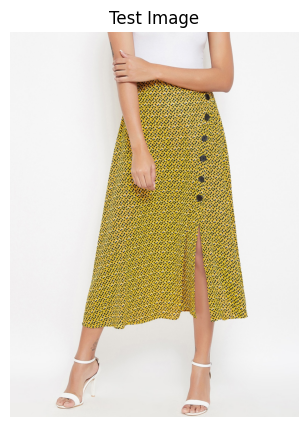


Text-to-Image Similarity Scores:
----------------------------------------
26.7%  black kurta with palazzos
3.4%  black long dress with pants
15.1%  black embroidered ethnic wear
54.1%  red floral dress
0.7%  blue jeans
0.1%  white t-shirt


In [ ]:
# Pick a sample image
sample_image_path = IMAGES_DIR / "0.jpg"

# Load and preprocess image
image = Image.open(sample_image_path)
image_input = preprocess_val(image).unsqueeze(0).to(device)

# Display the image
plt.figure(figsize=(4, 5))
plt.imshow(image)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Test text queries - mix of Western and Indian terms
test_texts = [
    "black kurta with palazzos",
    "black long dress with pants",
    "black embroidered ethnic wear",
    "red floral dress",
    "blue jeans",
    "white t-shirt"
]

# Encode
text_tokens = tokenizer(test_texts).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input, normalize=True)
    text_features = model.encode_text(text_tokens, normalize=True)
    
    # Similarity scores
    similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# Show results
print("\nText-to-Image Similarity Scores:")
print("-" * 40)
for text, score in zip(test_texts, similarities[0].cpu().numpy()):
print(f"{score:.1%}  {text}")

In [10]:
# More accurate text options for THIS image
test_texts_v2 = [
    "yellow printed midi skirt",
    "olive floral skirt with buttons",
    "yellow skirt with side slit",
    "black kurta",
    "red dress",
    "printed A-line skirt"
]

text_tokens = tokenizer(test_texts_v2).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens, normalize=True)
    similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Text-to-Image Similarity Scores (v2):")
print("-" * 40)
for text, score in zip(test_texts_v2, similarities[0].cpu().numpy()):
    print(f"{score:.1%}  {text}")

Text-to-Image Similarity Scores (v2):
----------------------------------------
99.2%  yellow printed midi skirt
0.3%  olive floral skirt with buttons
0.3%  yellow skirt with side slit
0.0%  black kurta
0.0%  red dress
0.2%  printed A-line skirt


CSV Row 0:
  Index (Unnamed: 0): 0
  Name: Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta
  Colour: Black
  Expected image: 0.jpg

Actual image at 0.jpg:


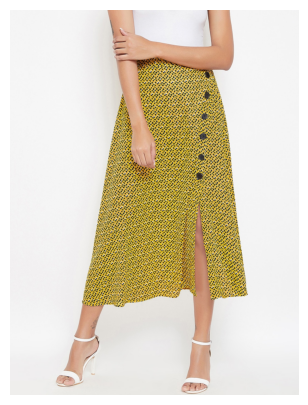

In [11]:
# Check what row 0 says in the CSV
print("CSV Row 0:")
print(f"  Index (Unnamed: 0): {df.iloc[0]['Unnamed: 0']}")
print(f"  Name: {df.iloc[0]['name']}")
print(f"  Colour: {df.iloc[0]['colour']}")
print(f"  Expected image: {df.iloc[0]['Unnamed: 0']}.jpg")

# Display the image at 0.jpg
print("\n" + "="*50)
print("Actual image at 0.jpg:")
img_0 = Image.open(IMAGES_DIR / "0.jpg")
plt.figure(figsize=(4,5))
plt.imshow(img_0)
plt.axis('off')
plt.show()

In [12]:
# Check if p_id maps to image filename
print("CSV Row 0:")
print(f"  p_id: {df.iloc[0]['p_id']}")

# Check if image with p_id exists
p_id = str(int(df.iloc[0]['p_id']))
print(f"  Looking for: {p_id}.jpg")
print(f"  Exists: {(IMAGES_DIR / f'{p_id}.jpg').exists()}")

# List some actual image filenames
print("\nSample image filenames in folder:")
import os
sample_files = sorted(os.listdir(IMAGES_DIR))[:10]
for f in sample_files:
    print(f"  {f}")

CSV Row 0:
  p_id: 17048614.0
  Looking for: 17048614.jpg
  Exists: False

Sample image filenames in folder:
  0.jpg
  10.jpg
  100.jpg
  1000.jpg
  10000.jpg
  10001.jpg
  10002.jpg
  10003.jpg
  10004.jpg
  10005.jpg


In [13]:
# Check image filename range
import os
all_images = os.listdir(IMAGES_DIR)
image_numbers = [int(f.replace('.jpg', '')) for f in all_images if f.endswith('.jpg')]

print(f"Total images: {len(image_numbers)}")
print(f"Min filename: {min(image_numbers)}.jpg")
print(f"Max filename: {max(image_numbers)}.jpg")
print(f"CSV rows: {len(df)}")

# Check if it's simply row index = image number
print(f"\nSequential check:")
print(f"Expected range: 0 to {len(df)-1}")
print(f"Actual range: {min(image_numbers)} to {max(image_numbers)}")

# Count missing
missing = set(range(max(image_numbers)+1)) - set(image_numbers)
print(f"Missing count: {len(missing)}")

Total images: 14481
Min filename: 0.jpg
Max filename: 14481.jpg
CSV rows: 14330

Sequential check:
Expected range: 0 to 14329
Actual range: 0 to 14481
Missing count: 1


In [14]:
# Look at the img column - maybe filename is embedded in URL
print("Sample image URLs:")
for i in range(3):
    print(f"\nRow {i}:")
    print(f"  URL: {df.iloc[i]['img']}")
    print(f"  p_id: {df.iloc[i]['p_id']}")

Sample image URLs:

Row 0:
  URL: http://assets.myntassets.com/assets/images/17048614/2022/2/4/b0eb9426-adf2-4802-a6b3-5dbacbc5f2511643971561167KhushalKWomenBlackEthnicMotifsAngrakhaBeadsandStonesKurtawit7.jpg
  p_id: 17048614.0

Row 1:
  URL: http://assets.myntassets.com/assets/images/16524740/2021/12/29/17ab2ac8-2e60-422d-9d20-2527415932361640754214931-STRAPPY-SET-IN-ORANGE-WITH-ORGANZA-DUPATTA-5961640754214349-2.jpg
  p_id: 16524740.0

Row 2:
  URL: http://assets.myntassets.com/assets/images/16331376/2021/12/2/b8c4f90f-683c-48d2-b8ac-19891a87c0651638428628378KurtaSets1.jpg
  p_id: 16331376.0


FileNotFoundError: [Errno 2] No such file or directory: '/home/sarv/projects/fashion-ensemble-builder/data/raw/myntra/images/1.jpg'

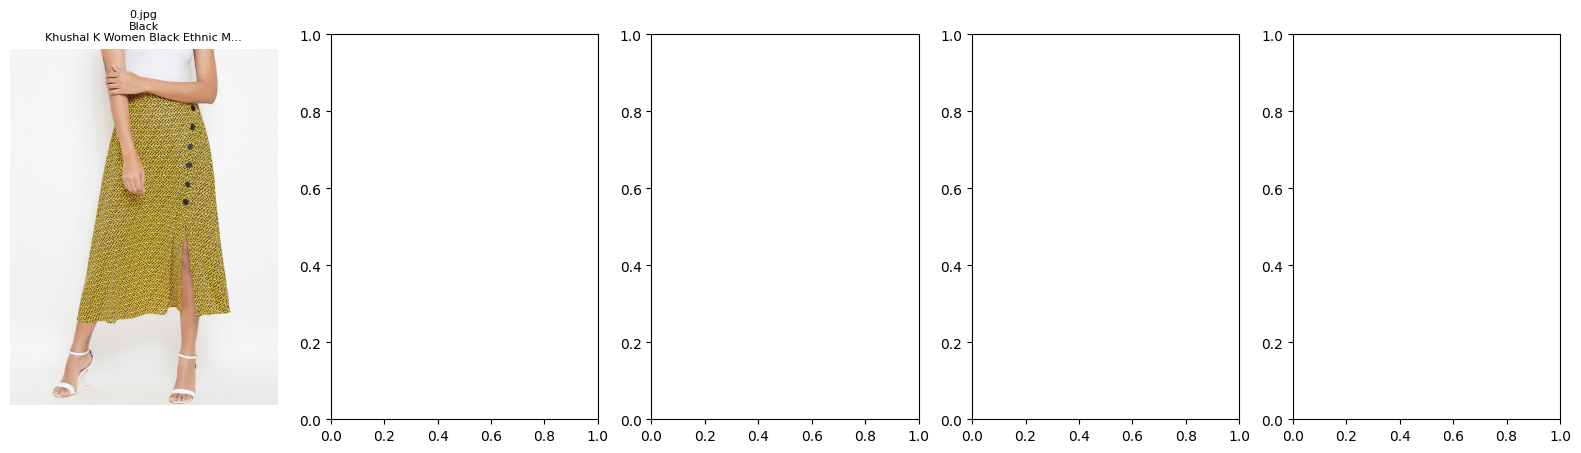

In [16]:
# Display first 5 images alongside their CSV descriptions
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    img_path = IMAGES_DIR / f"{i}.jpg"
    img = Image.open(img_path)
    
    axes[i].imshow(img)
    axes[i].axis('off')
    
    # Get CSV row where Unnamed: 0 == i
    row = df[df['Unnamed: 0'] == i]
    if len(row) > 0:
        title = f"{i}.jpg\n{row.iloc[0]['colour']}\n{row.iloc[0]['name'][:30]}..."
    else:
        title = f"{i}.jpg\nNo CSV match"
    
    axes[i].set_title(title, fontsize=8)

plt.tight_layout()
plt.show()

In [17]:
# Check which of first 10 indices exist
print("Checking first 10 indices:")
for i in range(10):
    img_path = IMAGES_DIR / f"{i}.jpg"
    exists = img_path.exists()
    print(f"  {i}.jpg: {'✓' if exists else '✗'}")

Checking first 10 indices:
  0.jpg: ✓
  1.jpg: ✗
  2.jpg: ✓
  3.jpg: ✓
  4.jpg: ✓
  5.jpg: ✓
  6.jpg: ✓
  7.jpg: ✓
  8.jpg: ✓
  9.jpg: ✓


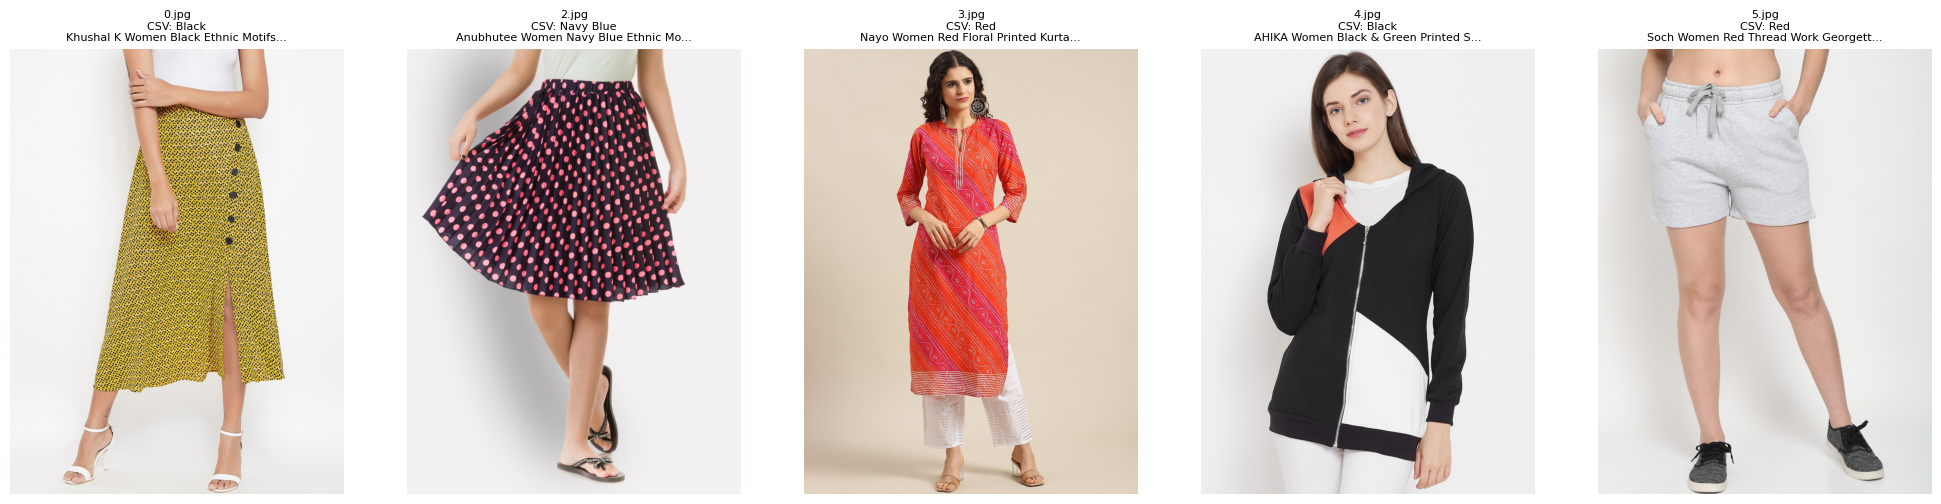

In [18]:
# Display images that exist alongside their CSV descriptions
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Use indices that exist
existing_indices = [0, 2, 3, 4, 5]

for ax_idx, i in enumerate(existing_indices):
    img_path = IMAGES_DIR / f"{i}.jpg"
    img = Image.open(img_path)
    
    axes[ax_idx].imshow(img)
    axes[ax_idx].axis('off')
    
    # Get CSV row where Unnamed: 0 == i
    row = df[df['Unnamed: 0'] == i]
    if len(row) > 0:
        colour = row.iloc[0]['colour']
        name = row.iloc[0]['name'][:35]
        title = f"{i}.jpg\nCSV: {colour}\n{name}..."
    else:
        title = f"{i}.jpg\nNo CSV match"
    
    axes[ax_idx].set_title(title, fontsize=8)

plt.tight_layout()
plt.show()

In [19]:
# Get all valid image paths (ignore CSV mapping)
all_images = sorted(IMAGES_DIR.glob('*.jpg'))

print(f"Total images found: {len(all_images)}")
print(f"First 5: {[img.name for img in all_images[:5]]}")
print(f"Last 5: {[img.name for img in all_images[-5:]]}")

# Store as list of paths
image_paths = [str(img) for img in all_images]

Total images found: 14481
First 5: ['0.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg']
Last 5: ['9995.jpg', '9996.jpg', '9997.jpg', '9998.jpg', '9999.jpg']


In [20]:
from tqdm import tqdm

def generate_embeddings(image_paths, model, preprocess, device, batch_size=32):
    """Generate embeddings for all images in batches."""
    all_embeddings = []
    valid_paths = []
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Generating embeddings"):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        batch_valid_paths = []
        
        for path in batch_paths:
            try:
                img = Image.open(path).convert('RGB')
                img_tensor = preprocess(img)
                batch_images.append(img_tensor)
                batch_valid_paths.append(path)
            except Exception as e:
                print(f"Error loading {path}: {e}")
                continue
        
        if batch_images:
            batch_tensor = torch.stack(batch_images).to(device)
            
            with torch.no_grad():
                embeddings = model.encode_image(batch_tensor, normalize=True)
            
            all_embeddings.append(embeddings.cpu().numpy())
            valid_paths.extend(batch_valid_paths)
    
    return np.vstack(all_embeddings), valid_paths

# Generate embeddings
embeddings, valid_paths = generate_embeddings(image_paths, model, preprocess_val, device, batch_size=64)

print(f"\nEmbeddings shape: {embeddings.shape}")
print(f"Valid images: {len(valid_paths)}")

Generating embeddings:  77%|███████▋  | 175/227 [05:14<01:27,  1.67s/it]

Error loading /home/sarv/projects/fashion-ensemble-builder/data/raw/myntra/images/7083.jpg: image file is truncated (2 bytes not processed)


Generating embeddings: 100%|██████████| 227/227 [06:45<00:00,  1.79s/it]


Embeddings shape: (14480, 512)
Valid images: 14480


In [21]:
# Save embeddings and paths for reuse
np.save(EMBEDDINGS_DIR / 'myntra_embeddings.npy', embeddings)

# Save valid paths as text file
with open(EMBEDDINGS_DIR / 'myntra_paths.txt', 'w') as f:
    for path in valid_paths:
        f.write(path + '\n')

print(f"Saved embeddings to: {EMBEDDINGS_DIR / 'myntra_embeddings.npy'}")
print(f"Saved paths to: {EMBEDDINGS_DIR / 'myntra_paths.txt'}")
print(f"Embeddings file size: {(EMBEDDINGS_DIR / 'myntra_embeddings.npy').stat().st_size / 1024 / 1024:.1f} MB")

Saved embeddings to: /home/sarv/projects/fashion-ensemble-builder/data/embeddings/myntra_embeddings.npy
Saved paths to: /home/sarv/projects/fashion-ensemble-builder/data/embeddings/myntra_paths.txt
Embeddings file size: 28.3 MB


In [22]:
import faiss

# Embeddings are already normalized, use Inner Product (= cosine similarity)
dimension = embeddings.shape[1]  # 512
index = faiss.IndexFlatIP(dimension)

# Add embeddings to index
index.add(embeddings.astype('float32'))

print(f"FAISS index built!")
print(f"Index size: {index.ntotal} vectors")

# Save index
faiss.write_index(index, str(EMBEDDINGS_DIR / 'myntra_faiss.index'))
print(f"Saved to: {EMBEDDINGS_DIR / 'myntra_faiss.index'}")

FAISS index built!
Index size: 14480 vectors
Saved to: /home/sarv/projects/fashion-ensemble-builder/data/embeddings/myntra_faiss.index


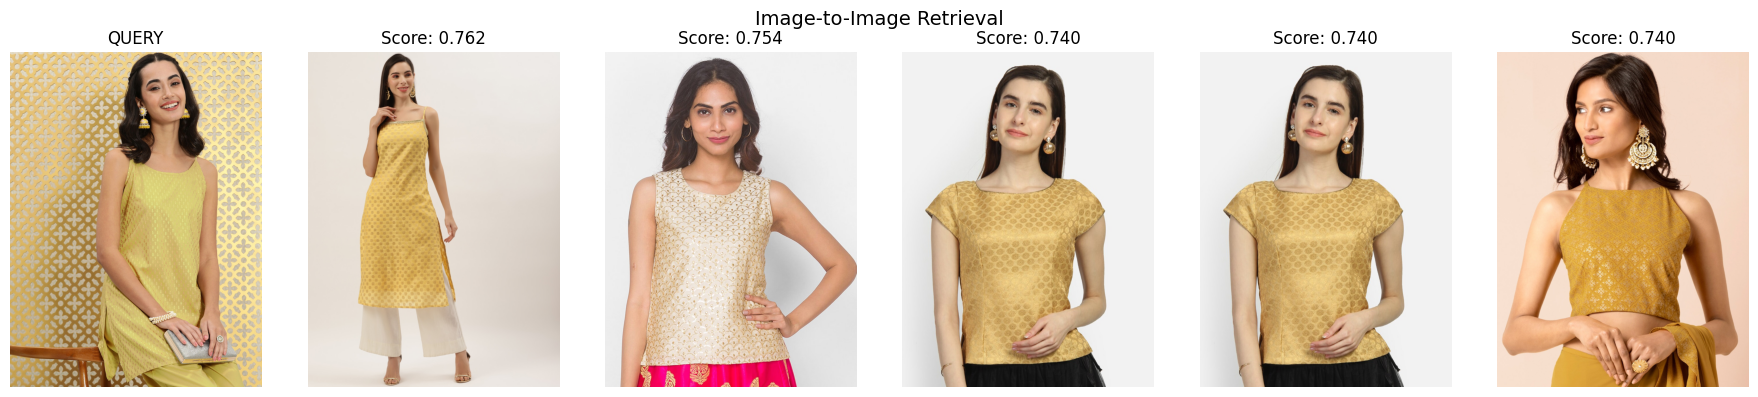

In [23]:
def search_similar(query_path, index, valid_paths, model, preprocess, device, k=5):
    """Find k most similar images to query."""
    # Load and embed query image
    img = Image.open(query_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        query_embedding = model.encode_image(img_tensor, normalize=True).cpu().numpy()
    
    # Search
    distances, indices = index.search(query_embedding.astype('float32'), k)
    
    return distances[0], indices[0]

# Test with a random image
query_path = valid_paths[100]

distances, indices = search_similar(query_path, index, valid_paths, model, preprocess_val, device, k=6)

# Display results (first result is the query itself)
fig, axes = plt.subplots(1, 6, figsize=(18, 4))

for i, (dist, idx) in enumerate(zip(distances, indices)):
    img = Image.open(valid_paths[idx])
    axes[i].imshow(img)
    axes[i].axis('off')
    title = "QUERY" if i == 0 else f"Score: {dist:.3f}"
    axes[i].set_title(title)

plt.suptitle("Image-to-Image Retrieval", fontsize=14)
plt.tight_layout()
plt.show()

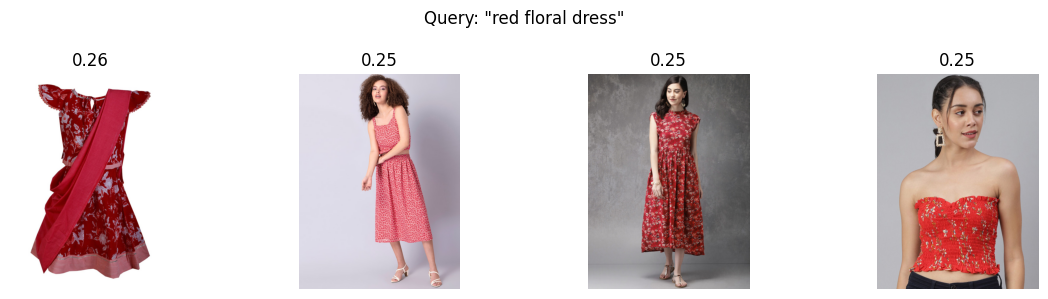

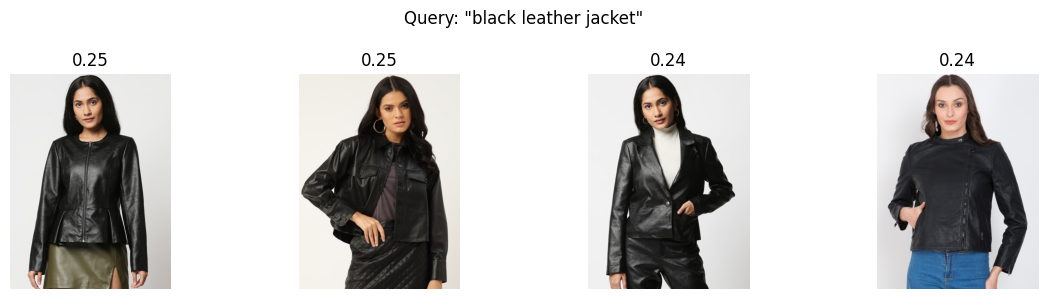

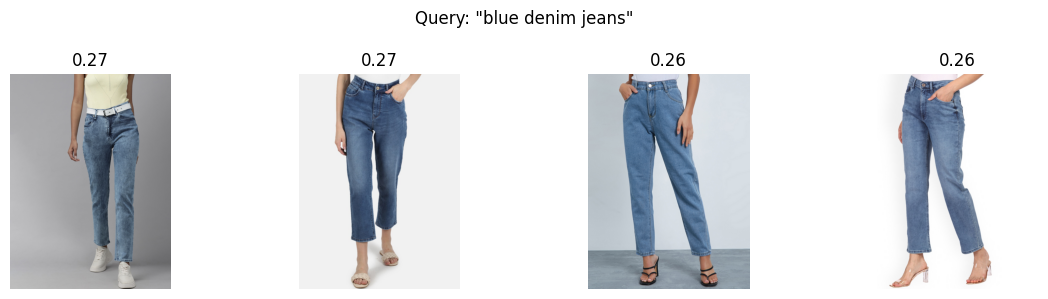

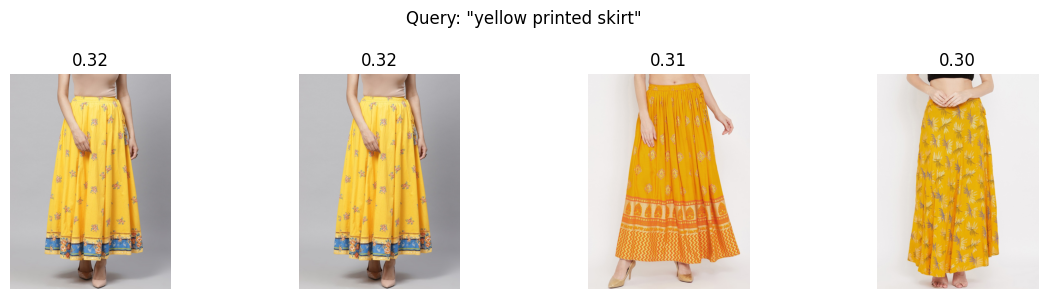

In [24]:
def search_by_text(query_text, index, valid_paths, model, tokenizer, device, k=5):
    """Find images matching text query."""
    text_tokens = tokenizer([query_text]).to(device)
    
    with torch.no_grad():
        text_embedding = model.encode_text(text_tokens, normalize=True).cpu().numpy()
    
    distances, indices = index.search(text_embedding.astype('float32'), k)
    
    return distances[0], indices[0]

# Test queries
test_queries = [
    "red floral dress",
    "black leather jacket",
    "blue denim jeans",
    "yellow printed skirt"
]

for query in test_queries:
    distances, indices = search_by_text(query, index, valid_paths, model, tokenizer, device, k=4)
    
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        img = Image.open(valid_paths[idx])
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{dist:.2f}")
    
    plt.suptitle(f'Query: "{query}"', fontsize=12)
    plt.tight_layout()
    plt.show()

In [25]:
import sys
sys.path.append(str(BASE_DIR / 'src'))

from color_theory import (
    calculate_color_compatibility,
    get_safe_combinations,
    find_complementary_colors,
    closest_color_name,
    assign_color_roles,
    ALL_COLORS_HSL,
    HarmonyType
)

from ensemble_rules import (
    get_garment_type,
    get_compatible_garments,
    build_ensemble_queries,
    suggest_outfit_structure,
    check_style_coherence,
    identify_garment_from_text
)

print("Modules imported successfully!")

Modules imported successfully!


In [26]:
# Test 1: Color compatibility
yellow_hsl = ALL_COLORS_HSL['yellow']
navy_hsl = ALL_COLORS_HSL['navy']

result = calculate_color_compatibility(yellow_hsl, navy_hsl)
print("Yellow + Navy compatibility:")
print(f"  Score: {result['overall_score']}")
print(f"  Compatible: {result['is_compatible']}")
print(f"  Harmony: {result['harmony_type']}")
print(f"  Details: {result['details']}")

print("\n" + "="*50)

# Test 2: Safe combinations
print("\nSafe combinations for 'yellow':")
print(get_safe_combinations('yellow'))

print("\nSafe combinations for 'maroon':")
print(get_safe_combinations('maroon'))

print("\n" + "="*50)

# Test 3: Find complementary colors
print("\nComplementary colors for yellow kurta:")
suggestions = find_complementary_colors(yellow_hsl, HarmonyType.COMPLEMENTARY)
for s in suggestions[:5]:
    print(f"  {s['name']}: {s['score']}")

Yellow + Navy compatibility:
  Score: 100
  Compatible: True
  Harmony: HarmonyType.NEUTRAL_ACCENT
  Details: {'note': 'Neutral color - universally compatible'}


Safe combinations for 'yellow':
['navy', 'grey', 'white', 'denim', 'purple', 'brown']

Safe combinations for 'maroon':
['gold', 'cream', 'pink', 'peach', 'mint']


Complementary colors for yellow kurta:
  navy: 100
  black: 85
  white: 85
  off_white: 85
  cream: 85


In [27]:
# Test 1: Get compatible garments
print("Compatible with 'kurta':")
print(get_compatible_garments('kurta'))

print("\nCompatible with 'tshirt':")
print(get_compatible_garments('tshirt'))

print("\n" + "="*50)

# Test 2: Identify garment from text
test_texts = [
    "yellow floral kurta with embroidery",
    "blue denim jeans",
    "black palazzo pants",
    "casual cotton tshirt"
]

print("\nGarment identification:")
for text in test_texts:
    garment = identify_garment_from_text(text)
    if garment:
        print(f"  '{text[:30]}...' → {garment.name} ({garment.category.value})")
    else:
        print(f"  '{text[:30]}...' → Not identified")

print("\n" + "="*50)

# Test 3: Style coherence
print("\nStyle coherence checks:")
pairs = [('kurta', 'palazzos'), ('kurta', 'jeans'), ('tshirt', 'blazer'), ('hoodie', 'trousers')]

for g1, g2 in pairs:
    result = check_style_coherence(g1, g2)
    print(f"  {g1} + {g2}: score={result['score']}, compatible={result['compatible']}")

Compatible with 'kurta':
['palazzos', 'salwar', 'churidar', 'jeans', 'dhoti_pants', 'leggings']

Compatible with 'tshirt':
['jeans', 'shorts', 'joggers', 'skirt', 'cargo_pants', 'chinos']


Garment identification:
  'yellow floral kurta with embro...' → kurta (top)
  'blue denim jeans...' → jeans (bottom)
  'black palazzo pants...' → palazzos (bottom)
  'casual cotton tshirt...' → shirt (top)


Style coherence checks:
  kurta + palazzos: score=100, compatible=True
  kurta + jeans: score=60, compatible=True
  tshirt + blazer: score=0, compatible=False
  hoodie + trousers: score=0, compatible=False


In [28]:
# Test build_ensemble_queries
print("Building ensemble for yellow kurta, festive occasion:")
print("="*50)

queries = build_ensemble_queries(
    anchor_garment='kurta',
    anchor_color='yellow',
    occasion='festive',
    style='ethnic',
    complementary_colors=['navy', 'white', 'gold', 'maroon']
)

for i, q in enumerate(queries, 1):
    print(f"\nQuery {i}:")
    print(f"  Garment: {q['garment_type']} ({q['garment_category']})")
    print(f"  Color: {q['color']}")
    print(f"  Search text: '{q['search_text']}'")

print("\n" + "="*50)

# Test user intent parsing
print("\nIntent parsing tests:")
test_inputs = [
    "find me a complete outfit for a wedding",
    "yellow kurta similar to this",
    "casual brunch look with jeans",
    "match this with palazzos"
]

for text in test_inputs:
    result = suggest_outfit_structure(text)
    print(f"\n'{text}'")
    print(f"  Intent: {result['intent']}")
    print(f"  Needs ensemble: {result['needs_full_ensemble']}")
    print(f"  Occasion: {result['detected_occasion']}")

Building ensemble for yellow kurta, festive occasion:

Query 1:
  Garment: palazzos (bottom)
  Color: navy
  Search text: 'navy palazzos festive ethnic'

Query 2:
  Garment: salwar (bottom)
  Color: white
  Search text: 'white salwar festive ethnic'

Query 3:
  Garment: churidar (bottom)
  Color: gold
  Search text: 'gold churidar festive ethnic'

Query 4:
  Garment: jeans (bottom)
  Color: maroon
  Search text: 'maroon jeans'


Intent parsing tests:

'find me a complete outfit for a wedding'
  Intent: ensemble
  Needs ensemble: True
  Occasion: wedding

'yellow kurta similar to this'
  Intent: similar
  Needs ensemble: False
  Occasion: None

'casual brunch look with jeans'
  Intent: similar
  Needs ensemble: True
  Occasion: brunch

'match this with palazzos'
  Intent: ensemble
  Needs ensemble: True
  Occasion: None


In [29]:
# End-to-end test: User query → Ensemble queries → FAISS search → Results

def build_outfit(user_text, anchor_image_path=None, k=5):
    """
    Full pipeline: parse intent, build queries, search FAISS.
    """
    results = {'anchor': None, 'ensemble_items': []}
    
    # 1. Parse user intent
    intent = suggest_outfit_structure(user_text, has_anchor_image=anchor_image_path is not None)
    print(f"Intent: {intent['intent']}, Occasion: {intent['detected_occasion']}")
    
    # 2. If anchor image provided, get similar items first
    if anchor_image_path:
        distances, indices = search_similar(anchor_image_path, index, valid_paths, model, preprocess_val, device, k=3)
        results['anchor'] = {
            'query_image': anchor_image_path,
            'similar': [valid_paths[i] for i in indices[1:]]  # Skip self
        }
    
    # 3. Detect anchor garment and color from text
    anchor_garment = intent.get('detected_garment', 'kurta')
    
    # Extract color from text (simple keyword match)
    detected_color = 'white'  # default
    for color in ['red', 'blue', 'yellow', 'green', 'black', 'white', 'pink', 'navy', 'maroon', 'gold']:
        if color in user_text.lower():
            detected_color = color
            break
    
    print(f"Detected: {anchor_garment} in {detected_color}")
    
    # 4. Get complementary colors
    complementary = get_safe_combinations(detected_color)
    print(f"Complementary colors: {complementary}")
    
    # 5. Build ensemble queries
    queries = build_ensemble_queries(
        anchor_garment=anchor_garment,
        anchor_color=detected_color,
        occasion=intent.get('detected_occasion'),
        complementary_colors=complementary[:4]
    )
    
    # 6. Run FAISS search for each query
    for q in queries:
        print(f"\nSearching: '{q['search_text']}'")
        distances, indices = search_by_text(q['search_text'], index, valid_paths, model, tokenizer, device, k=k)
        
        results['ensemble_items'].append({
            'query': q,
            'results': [{'path': valid_paths[i], 'score': float(d)} for i, d in zip(indices, distances)]
        })
    
    return results

# Test it
print("="*60)
print("TEST: Yellow kurta outfit for festive occasion")
print("="*60)

outfit = build_outfit("I need a festive outfit with my yellow kurta")

TEST: Yellow kurta outfit for festive occasion
Intent: ensemble, Occasion: festive
Detected: kurta in yellow
Complementary colors: ['navy', 'grey', 'white', 'denim', 'purple', 'brown']

Searching: 'navy palazzos festive'

Searching: 'grey salwar festive'

Searching: 'white churidar festive'

Searching: 'denim jeans'


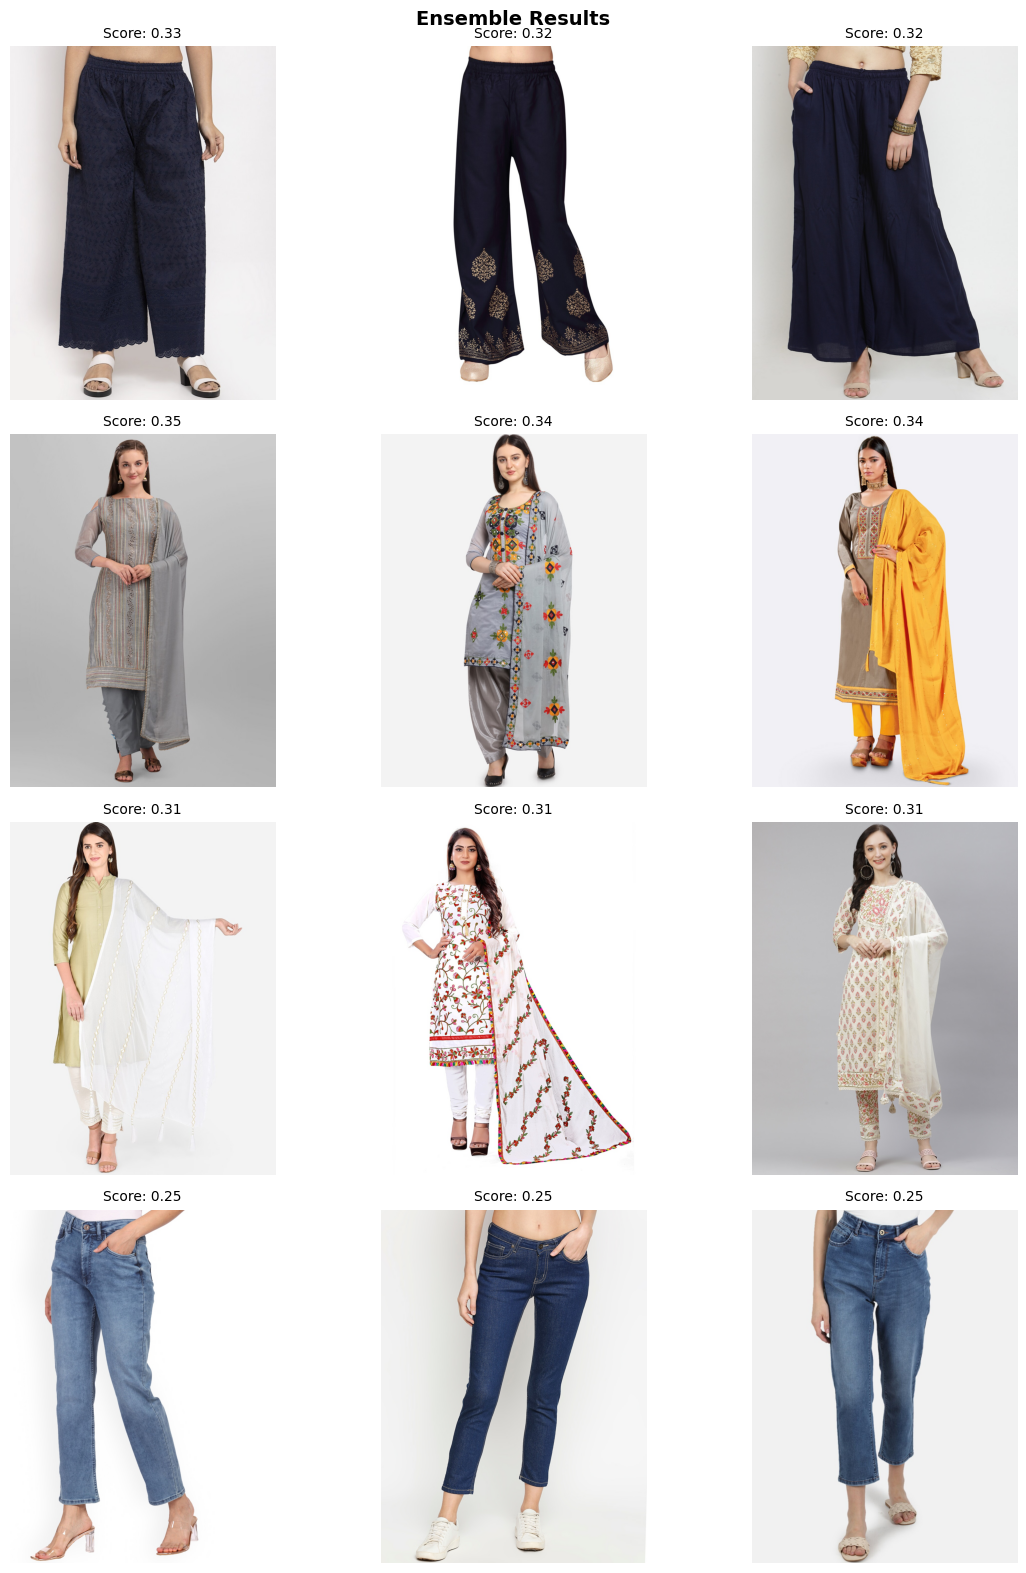

In [30]:
def display_outfit(outfit_results, items_per_query=3):
    """Display the outfit ensemble visually."""
    
    ensemble_items = outfit_results['ensemble_items']
    n_queries = len(ensemble_items)
    
    fig, axes = plt.subplots(n_queries, items_per_query, figsize=(items_per_query * 4, n_queries * 4))
    
    if n_queries == 1:
        axes = [axes]
    
    for row, item in enumerate(ensemble_items):
        query_text = item['query']['search_text']
        
        for col in range(items_per_query):
            ax = axes[row][col] if n_queries > 1 else axes[col]
            
            if col < len(item['results']):
                result = item['results'][col]
                img = Image.open(result['path'])
                ax.imshow(img)
                ax.set_title(f"Score: {result['score']:.2f}", fontsize=10)
            
            ax.axis('off')
        
        # Add query label on the left
        axes[row][0].set_ylabel(query_text, fontsize=10, rotation=0, labelpad=80, ha='right')
    
    plt.suptitle("Ensemble Results", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Display the outfit we just built
display_outfit(outfit)